# Simple 1-D Burger's POD-ROM

The problem we are solving is, for $ x\in [0,100] $ and $t\in [0, T]$:

\begin{align}\label{eq:burgers}
\begin{split}
    w_t + \frac{1}{2}\left(w^2\right)_x &= 0.02 e^{\mu_2 x}, \\
    w(0, t, \mu) &= \mu_1, \\
    w(x,0,\mu) &= 1.
\end{split}
\end{align}

In [1]:
# These are required
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt

# This is only necessary to load the previously prepared data
from torch import load

### This is the class managing the simulation.  

Computes ROM and (optionally) FOM with finite differences.  Supports loading data from my file or generating it from a list of parameter pairs.

In [2]:
class BurgersROM:
    
    def __init__(self):
        pass
        
    
    def POD_from_data(self, file, n):
        '''
        Loads snapshot data from my BurgersData file.
        Computes POD approximation after subtracting initial condition.
        '''
        data = load(file)
        S = data['S']
        M = data['M']
        
        tStart = perf_counter()
        for i in range(12):
            IC = np.ones(S.shape[1])
            IC[0] = M[101*i][1]
            S[101*i:101*(i+1)] = S[101*i:101*(i+1)] - IC.reshape(1,-1)
        self.POD = np.linalg.svd(S.T)[0][:,:n]
        tEnd = perf_counter()
        
        print(f'POD time is {tEnd-tStart}')
        
        
    def POD_from_parameters(self, N, Nt, t_max, mu_list, n):
        '''
        Computes a POD approximation from a user-defined list of parameters.
        '''
        sols = [0 for mu in mu_list]
        u0 = np.ones(N)
        for i, mu in enumerate(mu_list):
            sols[i] = self.solve_FOM(N, Nt, t_max, mu, verbose=False)
            u0[0] = mu[0]
            sols[i] = sols[i] - u0.reshape(-1,1)
        snapshots = np.concatenate(sols, axis=1)
        self.POD = np.linalg.svd(snapshots)[0][:,:n]
        
        
    def solve_FOM(self, N, Nt, t_max, mu, I=[0,100], verbose=True):
        '''
        Computes the (N x Nt) FOM solution at parameter mu.
        '''
        def f(u): return 0.5 * u**2  # Convenience function

        # Define parameters
        a, b = I
        dt = t_max / Nt
        x = np.linspace(a, b, N)
        dx = (b - a) / N

        # Define forcing.
        g = 0.02 * np.exp(mu[1] * x)

        # Set up the initial solution values.
        u0 = np.ones_like(x)
        u0[0] = mu[0]  # BC at left endpoint

        # Initialize quantities.
        U = np.zeros((Nt+1, N))
        U[0] = u0

        # Implementation of the numerical method.
        FOMtElapsed = 0
        for i in range(1, Nt+1):

            # Upwind conservative.
            FOMtStart = perf_counter()
            u = U[i-1]
            uNew = u
            uNew[1:] = u[1:] + dt * (-1 / dx * (f(u[1:]) - f(u[:-1])) + g[1:])

            FOMtEnd = perf_counter()
            FOMtElapsed = FOMtElapsed + FOMtEnd - FOMtStart

            # Save the latest result.
            U[i] = uNew

        if verbose is True: print(f'FOM time is {FOMtElapsed}')
        return U.T
    
    
    def assemble(self, mu, I=[0,100]):
        '''
        Assembles ROM system at parameter mu.  
        Uses POD basis computed earlier.
        '''
        a, b = I
        N = self.POD.shape[0]
        x = np.linspace(a, b, N)
        dx = (b - a) / N
        
        def tridiag(a, b, c, k1=-1, k2=0, k3=1):
            return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
        
        tStart = perf_counter()
        
        # Precompute quantities for ROM.
        PODinv = self.POD.T  # Since POD comes from unitary mtx
        self.gRed = PODinv @ (0.02 * np.exp(mu[1] * x))
        
        fdiag = np.insert(np.ones(N-1), 0, 0)
        FD = tridiag(-np.ones(N-1), fdiag, np.zeros(N-1)) / dx
        fd = PODinv @ FD  # low-dim FD matrix
        
        u0 = np.ones_like(x)
        u0[0] = mu[0]  # BC at left endpoint

        self.aVec = fd @ (0.5*u0**2)  # rank-1 term in (u^2)_x

        self.Bmat = fd @ np.diag(u0) @ self.POD  # rank-2 term in (u^2)_x

        outprod = np.tensordot(self.POD, self.POD, axes=0)
        temp = 0.5 * outprod.diagonal(axis1=0, axis2=2).transpose((2,1,0))
        self.Ctens = np.einsum('ij,jkl', fd, temp)  # rank-3 term in (u^2)_x
        
        tEnd = perf_counter()
        print(f'assembly time is {tEnd-tStart}')
        
    
    def solve_ROM(self, Nt, t_max, I=[0,100]):
        '''
        Forward Euler to solve the pre-assembled ROM.
        '''
        # Define parameters
        a, b = I
        dt = t_max / Nt
        N = self.POD.shape[0]
        x = np.linspace(a, b, N)
        dx = (b-a) / N
        
        # Initialize quantities.
        uRed0 = np.zeros(self.POD.shape[1])
        U = np.zeros((Nt+1, self.POD.shape[1]))
        U[0] = uRed0

        # Implementation of the numerical method.
        ROMtElapsed = 0
        for i in range(1,Nt+1):
            ROMtStart = perf_counter()
    
            uRed = U[i-1]
            uRed2 = np.tensordot(uRed, uRed, axes=0)
            uRedNew = uRed + dt * (self.gRed - self.aVec - self.Bmat @ uRed \
                                   - np.einsum('ijk,jk', self.Ctens, uRed2))
    
            ROMtEnd = perf_counter()
            ROMtElapsed = ROMtElapsed + ROMtEnd - ROMtStart

            #  Save the latest result.
            U[i] = uRedNew
    
        print(f'ROM time is {ROMtElapsed}')
        return U.T
    
    
    def reconstruct(self, approx, mu):
        '''
        Reconstruct approximation to the FOM solution at mu from approx.
        '''
        u0 = np.ones(self.POD.shape[0])
        u0[0] = mu[0]
        return u0.reshape(-1,1) + self.POD @ approx
        

## Testing

We test the convergence under refinement of the reduced dimension.  First, we use the POD basis computed from my saved data.

FOM time is 0.0009934199999994675
POD time is 0.10600366599999989
assembly time is 0.0015226660000000614
ROM time is 0.0024864909999999796
POD time is 0.10096429200000001
assembly time is 0.014811665999999946
ROM time is 0.002485086999997499
POD time is 0.09881341700000013
assembly time is 0.12948337499999996
ROM time is 0.004251752999997915


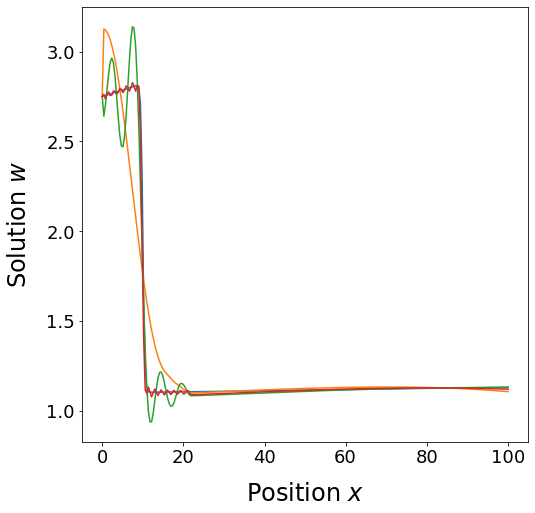

In [3]:
x = np.linspace(0, 100, 256)
mu = [2.75, 0.00275]

p=50

rom = BurgersROM()
sol = rom.solve_FOM(256, 100, 10, mu)

rom.POD_from_data('datasets/burgersData', 3)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol4 = rom.reconstruct(qqq, mu)

rom.POD_from_data('datasets/burgersData', 10)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol10 = rom.reconstruct(qqq, mu)

rom.POD_from_data('datasets/burgersData', 30)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol30 = rom.reconstruct(qqq, mu)

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('Position $x$', labelpad=15)
ax.set_ylabel('Solution $w$', labelpad=15)
ax.plot(x, sol[:,p])
ax.plot(x, sol4[:,p])
ax.plot(x, sol10[:,p])
ax.plot(x, sol30[:,p])
plt.show()

### Testing from parameters

Now, we test the basis computed from some random parameters.

FOM time is 0.0017968349999986089
assembly time is 0.0015519579999998534
ROM time is 0.0023578749999981774
assembly time is 0.003247416000000225
ROM time is 0.0026750050000003966
assembly time is 0.027729041999999815
ROM time is 0.003948339000001688


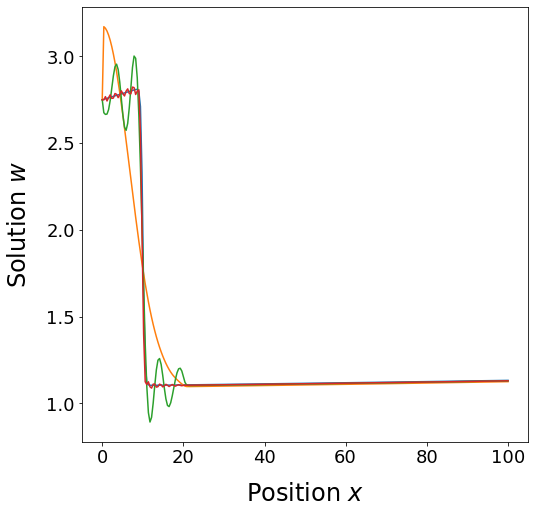

In [4]:
mu_list = np.array([0.5, 0.001]) + np.random.rand(10,2) * [3.5, 0.003]
x = np.linspace(0, 100, 256)

mu = [2.75, 0.00275]

p=50

rom = BurgersROM()
sol = rom.solve_FOM(256, 100, 10, mu)

rom.POD_from_parameters(256, 100, 10, mu_list, 3)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol4 = rom.reconstruct(qqq, mu)

rom.POD_from_parameters(256, 100, 10, mu_list, 10)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol10 = rom.reconstruct(qqq, mu)

rom.POD_from_parameters(256, 100, 10, mu_list, 30)
rom.assemble(mu)
qqq = rom.solve_ROM(100, 10)
sol30 = rom.reconstruct(qqq, mu)

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('Position $x$', labelpad=15)
ax.set_ylabel('Solution $w$', labelpad=15)
ax.plot(x, sol[:,p])
ax.plot(x, sol4[:,p])
ax.plot(x, sol10[:,p])
ax.plot(x, sol30[:,p])
plt.show()